# Comparing NkResearch's collection with UniKorea's collection
Listings available at https://unibook.unikorea.go.kr/

**Part I:** Crawling listing information from UniKorea's site

**Part II:** Finding omissions in each collection

**Part III:** Aligning article entries

**Part IV:** Investigating NkResearch's missing articles

**Part V:** String Similarity between titles


# Part I: Crawling UniKorea's site

In [1]:
import requests
from bs4 import BeautifulSoup
from itertools import groupby

page1 = "https://unibook.unikorea.go.kr/material/list?materialScope=SER&nation=kn&format=image&method=&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1&conjunctions=AND&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1%EC%A2%85%ED%95%A9%EB%8C%80%ED%95%99+%ED%95%99%EB%B3%B4&pageSize=10&sortField=publishYear&sortDirection=DESCENDING"
page2 = "https://unibook.unikorea.go.kr/material/list?materialScope=SER&nation=kn&format=image&method=&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1&conjunctions=AND&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1%EC%A2%85%ED%95%A9%EB%8C%80%ED%95%99+%ED%95%99%EB%B3%B4&pageSize=10&sortField=publishYear&sortDirection=DESCENDING&page=2"
pages = [page1,page2]

# finding all individual journal listings to recursively fetch them
# formatted as: [subject name, listing link]
listings = []
for page in pages:
    soup = BeautifulSoup(requests.get(page).content, "html.parser")
    for div in soup.find_all("li", {"class": "item-img"}):
        for img in div.find_all('img', alt=True):
            title = img['alt'].strip()
        a = div.findNext('a', href=True)
        link = a["href"]
        listings.append([title,link])

# deleting first one since it's a copy
del listings[0]
print ("Including journal {} with link \n{}, \na total of {} journal listings were found.".format(listings[0][0],listings[0][1],len(listings)))


Including journal 김일성종합대학 학보 : 력사학 with link 
view?materialScope=SER&nation=kn&format=image&method=&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1&conjunctions=AND&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1%EC%A2%85%ED%95%A9%EB%8C%80%ED%95%99+%ED%95%99%EB%B3%B4&pageSize=10&sortField=publishYear&sortDirection=DESCENDING&uid=CAT-20190700000000083, 
a total of 14 journal listings were found.


In [2]:
base = "https://unibook.unikorea.go.kr/material/"
all_listings = []
# visiting the link of each listing found earlier
for listing in listings:
    # adding base domain link to href
    listing_link = base+listing[1]
    # link with "checkins" loads collection information
    listing_link = listing_link.replace("view","checkins",1)
    
    # grabbing the link
    soup = BeautifulSoup(requests.get(listing_link).content, "html.parser")
    
    # scrapes table with info on each volume of the journal available
    combined = []
    for td in soup.find_all("td",{"align": "left"}):
        table = td.text.strip()
        # table contains data: [journal volume, publication date, date seized, acquisition status, 
        #                      total article count, href to each volume's information on the articles]
        combined.append(table)
        # finding href to recursively crawl each volume
        # there is one volume for each year; 
        # there are numbers within each volume
        for aa in td.find_all("a",href=True):
            combined.append(aa["href"])
    
    article_crawl = []
    # restructuring data to group volumes together
    volumes = [list(g) for k, g in groupby(combined, key=bool) if k]
    
    for volume in volumes:
        href = volume[-1]
        # adding href to base url again
        # recursively fetching article info for each volume listed
        article_link = base+href
        soup = BeautifulSoup(requests.get(article_link).content, "html.parser")
        articles = []
        # scraping table that lists the title, author, and page range
        # of each article belonging to that volume
        
        # tr = each table row
        for tr in soup.find_all('tr'):
            tds = []
            # td = data in each cell
            # each cell contains info on one article
            for td in tr.find_all("td"):
                tds.append (td.text.strip())
            articles.append(tds)
        # removing empties
        articles = [a for a in articles if a]
        articles = [a for a in articles if len(a) == 5]
        
        # deleting index row
        del articles[0]
        article_crawl.append([volume,articles])
    all_listings.append(article_crawl)
    print ("Finished crawling journal {}.".format(listing[0]))

Finished crawling journal 김일성종합대학 학보 : 력사학.
Finished crawling journal 김일성종합대학 학보 : 경제학.
Finished crawling journal 김일성종합대학 학보 : 지구환경과학 및 지질학.
Finished crawling journal 김일성종합대학 학보 : 수학.
Finished crawling journal 김일성종합대학 학보 : 생명과학.
Finished crawling journal 김일성종합대학 학보 : 화학.
Finished crawling journal 김일성종합대학 학보 : 물리학.
Finished crawling journal 김일성종합대학 학보 : 정보과학.
Finished crawling journal 김일성종합대학 학보 : 력사,법률.
Finished crawling journal 김일성종합대학 학보 : 철학,경제학.
Finished crawling journal 김일성종합대학 학보 : 어문학.
Finished crawling journal 김일성종합대학 학보 : 법률학.
Finished crawling journal 김일성종합대학 학보 : 철학.
Finished crawling journal 김일성종합대학 학보 : 자연과학.


In [3]:
subject_names = [l[0].split(": ")[1].strip() for l in listings]
print ("The available journals are:\n",", ".join(subject_names))


The available journals are:
 력사학, 경제학, 지구환경과학 및 지질학, 수학, 생명과학, 화학, 물리학, 정보과학, 력사,법률, 철학,경제학, 어문학, 법률학, 철학, 자연과학


In [4]:
# re-organizing crawled info into a dictionary
unikorea_crawl = dict(zip(subject_names, all_listings))

# cleaning data
import re
base = "https://unibook.unikorea.go.kr/material/"
for k,v in unikorea_crawl.items():
    for i,volume in enumerate(v):
        issue = re.findall(r'\d+', volume[0][0])
        issue = [d for d in issue if len(d) <= 2]
        vol,no = issue
        date_seized, status, collection_count = volume[0][2:5]
        link = base+volume[0][-1]
        volume[0] = [int(vol),int(no),date_seized,status,collection_count,link]
        
        for ii,articles in enumerate(volume[1]):
            del articles[2]
            del articles[0]
            articles[0] = articles[0].strip()
            authors = articles[1].replace(";",",")
            authors = authors.split(",")
            authors = [a.strip() for a in authors]
            authors = ",".join(authors)
            articles[1] = authors

# removing duplicate article listings
for k,v in unikorea_crawl.items():
    for volume in v:
        new_v = set(tuple(x) for x in volume[1])
        new_v = [list(x) for x in new_v]
        volume[1] = new_v

# removing index lists & empty lists
for k,v in unikorea_crawl.items():
    for i,volume in enumerate(v):
        info,articles = volume
        articles = [article for article in articles if "영문목차" not in article]
        articles = [article for article in articles if "편집부" not in article]
        volume[1] = [article for article in articles if "" not in article]


In [5]:
# restructuring page numbers from original 
# string '046-057' format into integer list [46,57]
for k,v in unikorea_crawl.items():
    for volume in v:
        for i,article in enumerate(volume[1]):
            start_page,end_page = article[-1].split("-")
            start_page = int(start_page.lstrip("0"))
            end_page = int(end_page.lstrip("0"))
            volume[1][i] = [article[0],article[1],start_page,end_page]
            
            
# removing duplicate entries by checking page numbers
# then sorting by page numbers
for k,v in unikorea_crawl.items():
    for i,volume in enumerate(v):
        seen = set()
        cond1 = [x for x in volume[1] if x[2] not in seen and not seen.add(x[2])]
        cond2 = [x for x in cond1 if x[3] not in seen and not seen.add(x[3])]
        cond3 = sorted(cond2, key = lambda x: int(x[3]))
        v[i][1] = cond3


In [6]:
# saving to json
import json
with open('unikorea_crawl.json', 'w') as f:
    json.dump(unikorea_crawl, f, ensure_ascii=False, indent=2)

In [7]:
# reloading for safety
import json
with open('unikorea_crawl.json',"r") as f:
    unikorea_crawl = json.load(f)

In [8]:
print("\033[01mExample of data structure\033[0m")
print("\033[01m--------------------------\033[0m")
for k,v in unikorea_crawl.items():
    print("\033[01mSubject\033[0m:", k)
    print ("\n\033[01mListing of journals per subject\033[0m: (volume, no, date seized, status, number of articles) ")
    print (v[0][0])
    print("\n\033[01mEach article nested within the listing\033[0m: (title, author, page range) ")
    for articles in v[0][1]:
        print (articles)
    break

Example of data structure
--------------------------
Subject: 력사학

Listing of journals per subject: (volume, no, date seized, status, number of articles) 
[65, 2, '2019-12-31', '입수', '20건', 'https://unibook.unikorea.go.kr/material/articles;jsessionid=NH1m0RIxj8Cxm6DdN1JvG81R.web11?checkinNo=115646&materialScope=SER&nation=kn&format=image&method=&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1&conjunctions=AND&fields=ALL&keywords=%EA%B9%80%EC%9D%BC%EC%84%B1%EC%A2%85%ED%95%A9%EB%8C%80%ED%95%99+%ED%95%99%EB%B3%B4&pageSize=10&sortField=publishYear&sortDirection=DESCENDING&uid=CAT-20190700000000083']

Each article nested within the listing: (title, author, page range) 
['과학기술발전에서 새로운 비약을 이룩하며 과학으로 흥하는 시대를 열어놓은 불멸의 령도업적', '김성옥', 2, 14]
['모란봉전자악단을 우리 당의 사상과 정책을 옹위하는 제일나팔수로 키워주신 불멸의 업적', '김경철', 15, 24]
['사회주의보건제도의 우월성을 높이 발양시켜 나가기 위한 현명한 령도', '오진명', 25, 33]
['고조선에 대한 실학자들의 견해분석', '최연주', 34, 45]
['고구려성의 건설설계연구', '박준호', 46, 57]
['고구려시기 무덤건설규정연구', '리광희', 58, 72]
['조선의 민속놀이 윷놀이에 대한 분석', '김경순', 73,

# Part II: Journal Omissions

To align and compare the collections, we first identify entire journals missing from eachother's collection. We start with journals in UniKorea missing from NkResesearch, i.e., set theoretic difference U\N. To index NkResearch journals relative to UniKorea, we use only the journal identification indices (subject, volume, no) found in UniKorea. 

In [9]:
import difflib
from operator import itemgetter

with open('bank.json',"r") as f:
    bank = json.load(f)
    
unikorea_indexed = []

for subject,data in unikorea_crawl.items():
    for volume in data:
        ## finding journal match
        vol,no = volume[0][:2]
        hashes = []
        
        ## iterating bank for hashes
        for md5hash,metadata in bank.items():
            j = metadata["Journal"]
            if j["Name"] == subject:
                if j["Volume"] == vol:
                    if j["No"] == no:
                        hashes.append(md5hash)
        
        ## keying those hashes to compare information:
        nkresearch = []
        for h in hashes:
            title = bank[h]["Title"].strip()
            author = ",".join(bank[h]["Author"])
            nkresearch.append([title,author])
        
        nkresearch = sorted(nkresearch, key=itemgetter(0))
        unikorea = [article[:2] for article in volume[1]]
        unikorea = sorted(unikorea, key=itemgetter(0))
        
        unikorea_indexed.append([[subject,vol,no],nkresearch,unikorea])

Empty indexed sets would thus mean NkResearch does not contain that journal.

In [10]:
import pandas as pd

# styling
def make_bold(var):
    return "\033[01m"+str(var)+"\033[0m"

multiindex_labels = []
dfs = []
nkr_missing_journals = []
for [index,nkresearch,unikorea] in unikorea_indexed:
    if not nkresearch:
        nkr_missing_journals.append([index,unikorea])
        
        # creating df
        journal_tuple = (index[0],index[1],index[2])
        multiindex_labels.append(journal_tuple)
        df_uni=pd.DataFrame({'Title':[u[0] for u in unikorea],'Author':[u[1] for u in unikorea]})
        dfs.append(df_uni)

nkr_missing_articles = [len(journal[1]) for journal in nkr_missing_journals]
nkr_missing_articles = sum(nkr_missing_articles)
print(make_bold("NkResearch is missing {} journals with a total of {} articles relative to UniKorea:".format(len(nkr_missing_journals),nkr_missing_articles)))

nkr_missing_df = pd.concat(dfs,keys=multiindex_labels)

# saving table above to excel
# pip install XlsxWriter
import xlsxwriter

writer = pd.ExcelWriter('nkresearch_missing.xlsx', engine='xlsxwriter')
nkr_missing_df.to_excel(writer, sheet_name='Sheet1',engine='xlsxwriter')
writer.save()

nkr_missing_df

NkResearch is missing 28 journals with a total of 929 articles relative to UniKorea:


Title Author
력사,법률 59 4 0                                  15세기 품계의 종류에 대한 분석    양영걸
           1          강성국가선설의 요구에 맞게 사회주의사상적위력을 백방으로 강화하신 위대한 령도    최성철
           2           경애하는 김정은동지께서 수령영생위업실현의 법적담보를 마련해주신 불멸의 업적    조용봉
           3   경애하는 김정은동지의 사상과 령도를 충정으로 받들어나가는것은 주체혁명위업의 승리를 ...    심명진
           4                                    고려말 과전법실시의 반동적본질    김은택
...                                                          ...    ...
어문학   58 1 28                            조선말련관사전편찬에서 제기되는 몇가지 문제    민영화
           29               출판보도물을 통하여 제국주의자들이 벌리고있는 여론조작책동의 반동성    조대현
           30                                   틀리론에 대한 인지언어학적연구     윤남
           31                              현대도이췰란드어성구의 본문호상간 유연성    리명호
           32                 현대로어의 각이한 기능문체들에서 쓰이는 일부 주성분들의 표현들    리명용

[929 rows x 2 columns]

There are three subjects missing.

Repeating the above steps for UniKorea:

In [11]:
# getting all [name, vol, no] found in nkresearch
nkr_idx = []
for md5hash,metadata in bank.items():
    j = metadata["Journal"]
    nkr_idx.append([j["Name"],j["Volume"],j["No"]])
# removing duplicate entries
nkr_idx = [list(tupl) for tupl in {tuple(item) for item in nkr_idx}]

# keying articles for each [name, vol, no] found
journal_hashes = []
for journal in nkr_idx:
    name,vol,no = journal
    hashes = []
    for md5hash,metadata in bank.items():
        j = metadata["Journal"]
        if j["Name"]==name and j["Volume"] == vol and j["No"] == no:
            hashes.append(md5hash)
    journal_hashes.append([journal,hashes])


nkresearch_indexed = []
for j in journal_hashes:
    journal,hashes = j
    name,vol,no = journal
    ## keying those hashes to compare information:
    nkresearch = []
    for h in hashes:
        title = bank[h]["Title"].strip()
        author = ",".join(bank[h]["Author"])
        nkresearch.append([title,author])
    
    unikorea = []
    if journal[0] in unikorea_crawl:
        for data in unikorea_crawl[journal[0]]:
            info,articles = data
            if journal[1:] == info[:2]:
                unikorea = articles
                
    nkresearch_indexed.append([journal,nkresearch,unikorea])

In [12]:
multiindex_labels = []
dfs = []
uni_missing_journals = []
for [index,nkresearch,unikorea] in nkresearch_indexed:
    if not unikorea:
        uni_missing_journals.append([index,nkresearch])
        
        # creating df
        journal_tuple = (index[0],index[1],index[2])
        multiindex_labels.append(journal_tuple)
        df_uni=pd.DataFrame({'Title':[n[0] for n in nkresearch],'Author':[n[1] for n in nkresearch]})
        dfs.append(df_uni)

uni_missing_articles = [len(journal[1]) for journal in uni_missing_journals]
uni_missing_articles = sum(uni_missing_articles)
print(make_bold("UniKorea is missing {} journals with a total of {} articles relative to NkResearch:".format(len(uni_missing_journals),uni_missing_articles)))

uni_missing_df = pd.concat(dfs,keys=multiindex_labels)
# saving table above to excel

writer = pd.ExcelWriter('unikorea_missing.xlsx', engine='xlsxwriter')
uni_missing_df.to_excel(writer, sheet_name='Sheet1',engine='xlsxwriter')
writer.save()
uni_missing_df

UniKorea is missing 79 journals with a total of 1975 articles relative to NkResearch:


Title       Author
어문학 66 2 0                                영어은유에 대한 사회문화적배경분석          김혜순
         1                                   조선어의 기준 － 평양문화어           안성
         2                  신경언어학연구에서 제기되는 언어장애에 대한 어휘의미론적분석          전룡진
         3                                   초기근대영어의 주요문체적특징          김광혁
         4                        순차통역을 위한 요점적기에서 나서는 몇가지 문제          한명일
...                                                      ...          ...
화학  66 2 23                                      에톡시나프탈렌의 합성      안광철,홍충심
         24                   o－페닐렌디아민과 뇨소축합에 의한 벤즈이미다졸론의 제조  박혁일,박철웅,홍영범
         25  아림계 및 초림계수마당에서 제조된 층간TiO2기둥형몬모릴론석의 기공구조특성과 표면산성      김일룡,박현일
         26                   La3+을 첨가한 나노TiO2－x빛촉매의 보임빛응답특성      김명학,김경일
         27                       피리딘중화법에 의한 테트라이소프로폭시티탄의 합성          김용학

[1975 rows x 2 columns]

There are 1975 articles missing, which makes up ~30% of all articles. As the lack of an UniKorea counterpart removes a baseline for that NkResearch journal entry, the exact discrepancies were analyzed by subject & year.


In [13]:
# grabbing all the years first
unikorea_vols = []
for subject,volumes in unikorea_crawl.items():
    unikorea_vols.append([volume[0][0] for volume in volumes])
unikorea_vols = [item for sublist in unikorea_vols for item in sublist]
unikorea_vols = list(set(unikorea_vols))

# since UniKorea does not explicitly state the year, we must deduce the year.
# one volume released per year; volume+1954 = year of release
# 1954 is the year after the Korean War ended
unikorea_years = sorted([vol+1954 for vol in unikorea_vols])
print ("Found years {} for UniKorea".format(unikorea_years))

nkresearch_years = [metadata["Journal"]["Year"] for md5hash,metadata in bank.items()]
nkresearch_years = sorted(list(set(nkresearch_years)))
print ("Found years {} for NkResearch\n".format(nkresearch_years))

all_years = sorted(list(set(unikorea_years+nkresearch_years)))
print ("All publication years:",all_years)

Found years [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019] for UniKorea
Found years [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021] for NkResearch

All publication years: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]


In [14]:
# grabbing subject info from each year
unikorea_subjects = [subject for subject in unikorea_crawl]
nkresearch_subjects = [metadata["Journal"]["Name"] for md5hash,metadata in bank.items()]

unikorea_subjects = list(set(unikorea_subjects))
nkresearch_subjects = list(set(nkresearch_subjects))
all_subjects = list(set(unikorea_subjects+nkresearch_subjects))
print(all_subjects)

['력사학', '경제학', '화학', '어문학', '수학', '법률학', '생명과학', '철학', '정보과학', 'NATURAL SCIENCE', 'SOCIAL SCIENCE', '력사,법률', '지구환경과학 및 지질학', '물리학', '자연과학', '철학,경제학']


In [15]:
import collections
import numpy as np

# reformatted subjects according to category
all_subjects = ['NATURAL SCIENCE','SOCIAL SCIENCE', 
                '철학,경제학','철학','경제학','력사,법률','력사학','법률학','어문학',
                '물리학','생명과학','수학','지구환경과학 및 지질학','정보과학','화학','자연과학',]

# getting subjects info by year
nkr_journals = []
nkr_year_subject = {}
for year in all_years:
    nkr_articles = [metadata["Journal"] for md5hash,metadata in bank.items() if metadata["Journal"]["Year"] == year]
    nkr_journal = [dict(t) for t in {tuple(d.items()) for d in nkr_articles}]
    nkr_journals.append(len(nkr_journal))
    nkr_subjects = [m["Name"] for m in nkr_articles]
    counts = collections.Counter(nkr_subjects)
    nkr_year_subject[year] = dict(counts.items())

nkr_matrix = [] # 2D matrix of number of articles per subject per year
for year,subj_count in nkr_year_subject.items():
    if not subj_count:
        nkr_matrix.append([0]*len(all_subjects))
    else:
        nkr_data = []
        for subject in all_subjects:
            if subject not in subj_count:
                nkr_data.append(0)
                continue
            else:
                nkr_data.append(subj_count[subject])
                continue
        nkr_matrix.append(nkr_data)
nkr_matrix = np.array(nkr_matrix)
nkr_df = pd.DataFrame(data=nkr_matrix, index=all_years, columns=all_subjects).T # transposing for aesthetic

# repeating for unikorea
uni_data = [] # list of articles for each subject per year

for year in all_years:
    yr_val = []
    for subject in all_subjects:
        subject_val = []
        if subject not in unikorea_crawl:
            subject_val.append(0)
        else:
            for volume in unikorea_crawl[subject]:
                if volume[0][0] == year-1954:
                    subject_val.append(len(volume[1]))
        yr_val.append(subject_val)
    uni_data.append(yr_val)
# summing list for 2d matrix
uni_matrix = []
for val in uni_data:
    summed = [sum(v) for v in val]
    uni_matrix.append(summed)
uni_matrix = np.array(uni_matrix)

uni_df = pd.DataFrame(data=uni_matrix, index=all_years, columns=all_subjects).T
display_df = pd.concat([nkr_df,uni_df],keys=["NkResearch","UniKorea"])

#saving to excel
with pd.ExcelWriter('collection_stats_by_year.xlsx') as writer:
    display_df.to_excel(writer, sheet_name='Sheet1',engine='xlsxwriter')
display_df

2011  2012  2013  2014  2015  2016  2017  2018  \
NkResearch NATURAL SCIENCE     0     0     0   133    23     0     0     0   
           SOCIAL SCIENCE      0     0     0    59     0     0     0     0   
           철학,경제학              0     0     0   127   139   151   124   128   
           철학                  0     0     0     0     0     0     0     0   
           경제학                 0     0     0     0     0     0     0     0   
           력사,법률               0     0     0   125   117   108   109    93   
           력사학                 0     0     0     0     0     0     0     0   
           법률학                 0     0     0     0     0     0     0     0   
           어문학                 0     0     0   135   112   120   101   108   
           물리학                 0     0     0     0     0     0     0   147   
           생명과학                0     0     0     0     0     0     0   116   
           수학                  0     0     0     0     0     0     0   108   
           지구환경과학 및 지질학        0     0     0     0     0     0     0   116   
           정보과학                0     0     0     0     0     0     0   103   
           화학                  0     0     0     0     0     0     0   142   
           자연과학                0     0     0   269   425   475   565     0   
UniKorea   NATURAL SCIENCE     0     0     0     0     0     0     0     0   
           SOCIAL SCIENCE      0     0     0     0     0     0     0     0   
           철학,경제학             71   142   145   127   139   151   123   128   
           철학                  0     0     0     0     0     0     0     0   
           경제학                 0     0     0     0     0     0     0     0   
           력사,법률              61   120   136   125   116   108   109    93   
           력사학                 0     0     0     0     0     0     0     0   
           법률학                 0     0     0     0     0     0     0     0   
           어문학                 0   136   118   135   112   120   101   109   
           물리학                 0     0     0     0     0     0     0   146   
           생명과학                0     0     0     0     0     0     0   115   
           수학                  0     0     0     0     0     0     0   107   
           지구환경과학 및 지질학        0     0     0     0     0     0     0   115   
           정보과학                0     0     0     0     0     0     0   102   
           화학                  0     0     0     0     0     0     0   141   
           자연과학                0     0     0     0   206   473   562     0   

                            2019  2020  2021  
NkResearch NATURAL SCIENCE    11     0     0  
           SOCIAL SCIENCE     14     0     0  
           철학,경제학              0     0     0  
           철학                 26    10    11  
           경제학                25    26    14  
           력사,법률               0     0     0  
           력사학                19    21    11  
           법률학                20    19    10  
           어문학                26    23    10  
           물리학               120   108    84  
           생명과학               98    98    66  
           수학                125   115    79  
           지구환경과학 및 지질학      113   116    78  
           정보과학               88    88    71  
           화학                132   111    79  
           자연과학                0     0     0  
UniKorea   NATURAL SCIENCE     0     0     0  
           SOCIAL SCIENCE      0     0     0  
           철학,경제학              0     0     0  
           철학                 26     0     0  
           경제학                25     0     0  
           력사,법률               0     0     0  
           력사학                19     0     0  
           법률학                19     0     0  
           어문학                26     0     0  
           물리학               118     0     0  
           생명과학               96     0     0  
           수학                123     0     0  
           지구환경과학 및 지질학      112     0     0  
           정보과학               86     0     

In [16]:
nkr_subject = {}
for subj in all_subjects:
    nkr_articles = [metadata["Journal"] for md5hash,metadata in bank.items() if metadata["Journal"]["Name"] == subj]
    nkr_subject[subj] = len(nkr_articles)
nkr_subject

{'NATURAL SCIENCE': 167,
 'SOCIAL SCIENCE': 73,
 '철학,경제학': 669,
 '철학': 47,
 '경제학': 65,
 '력사,법률': 552,
 '력사학': 51,
 '법률학': 49,
 '어문학': 635,
 '물리학': 459,
 '생명과학': 378,
 '수학': 427,
 '지구환경과학 및 지질학': 423,
 '정보과학': 350,
 '화학': 464,
 '자연과학': 1734}

In [17]:
nkr = {'NATURAL SCIENCE': 167,
 'SOCIAL SCIENCE': 73,
 'Physics': 459,
 'Life Science': 378,
 'Math': 427,
 'Environmental Science & Geology': 423,
 'Informatics': 350,
 'Chemistry': 464,
 'Nature Science': 1734,
'Philosophy & Economics': 669,
 'Philosophy': 47,
 'Economics': 65,
 'History & Law': 552,
 'History': 51,
 'Law': 49,
 'Literature': 635,
}

df = pd.DataFrame.from_dict(nkr,orient='index').T
with pd.ExcelWriter('subjects.xlsx') as writer:
    df.to_excel(writer, sheet_name='Sheet1',engine='xlsxwriter')

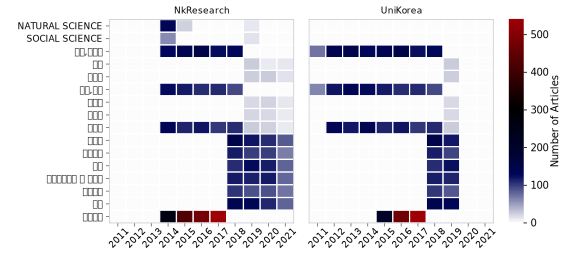

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib
from IPython.display import set_matplotlib_formats
from matplotlib import rc
from matplotlib import colors

set_matplotlib_formats('svg')
matplotlib.rcParams['svg.fonttype'] = 'none'

plt.rc('font', family='Arial Unicode MS')
plt.rcParams['font.family'] = ['Arial Unicode MS']

divnorm=colors.TwoSlopeNorm(vmin=0, vcenter=190, vmax=540)
# custom color bar
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", ["#fcfcfc",'#000659','#000000','#9e0005'])

fig,(ax1,ax2,axcb) = plt.subplots(1,3,figsize=(8,3.7),gridspec_kw={'width_ratios':[1,1,0.08]})
ax1.get_shared_y_axes().join(ax2)
g1 = sns.heatmap(nkr_df,cmap=my_cmap,cbar=False, robust=True, ax=ax1,linecolor='w',linewidths=1.2,vmax=568, norm=divnorm)
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(uni_df,cmap=my_cmap,ax=ax2,robust=True, cbar_ax=axcb,linecolor='w',linewidths=1.2,vmax=568, norm=divnorm)
g2.set_ylabel('')
g2.set_xlabel('')
g2.set_yticks([])

ax1.set_title('NkResearch',ha='center',size=9)
ax2.set_title('UniKorea',ha='center',size=9)

# may be needed to rotate the ticklabels correctly:
for ax in [g1,g2]:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor('#cacccf')
    tl = ax.get_xticklabels()
    ax.set_xticklabels(tl, rotation=45,size=9)
    ax.tick_params(color='#646970')
    tly = ax.get_yticklabels()
    ax.set_yticklabels(tly, rotation=0,size=9)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
axcb.set_ylabel("Number of Articles")
fig.tight_layout()
plt.savefig('heatmap.png',dpi=1200)

plt.show()

In [19]:
# getting complete stats by year

nkr_year_stats = []
for i,(year,subject) in enumerate(nkr_year_subject.items()):
    s = len(subject)
    a = sum(list(subject.values()))
    j = nkr_journals[i]
    nkr_year_stats.append([s,j,a])

uni_year_stats = []
for year in uni_data:
    s = []
    j = []
    a = []
    for i,subject in enumerate(year):
        if subject and sum(subject) > 0:
            s.append(i)
            j.append(len(subject))
            a.append(sum(subject))
    s = list(set(s))
    uni_year_stats.append([len(s),sum(j),sum(a)])
uni_df = pd.DataFrame(uni_year_stats,columns=['Subject','Volume','Article'],index=all_years)
nkr_df = pd.DataFrame(nkr_year_stats,columns=['Subject','Volume','Article'],index=all_years)
df = pd.concat([nkr_df,uni_df],keys=["NkResearch","UniKorea"])
df

Subject  Volume  Article
NkResearch 2011        0       0        0
           2012        0       0        0
           2013        0       0        0
           2014        6      26      848
           2015        5      25      816
           2016        4      24      854
           2017        4      24      899
           2018        9      36     1061
           2019       13      36      817
           2020       11      33      735
           2021       11      23      513
UniKorea   2011        2       4      132
           2012        3      12      398
           2013        3      12      399
           2014        3      12      387
           2015        4      18      573
           2016        4      24      852
           2017        4      24      895
           2018        9      36     1056
           2019       11      34      780
           2020        0       0        0
           2021        0       0        0

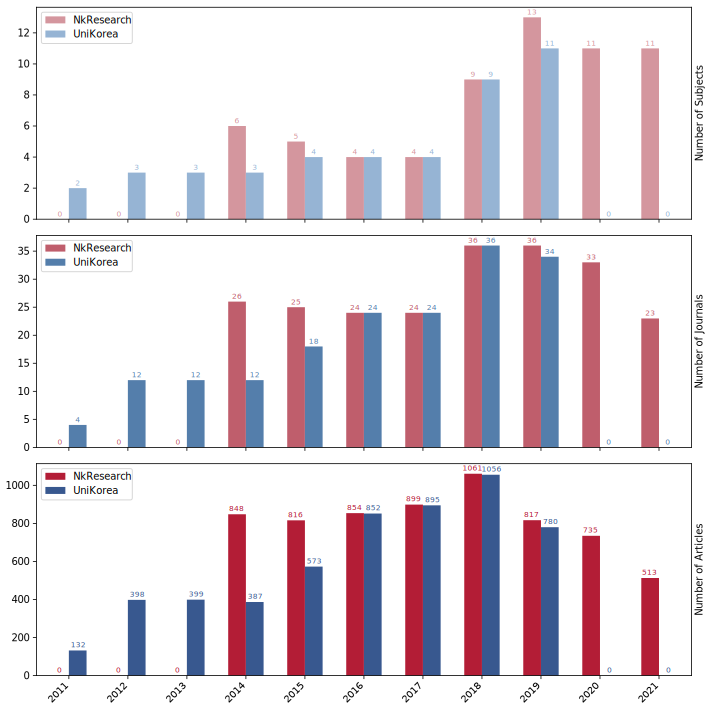

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,sharex=True,sharey=False,figsize=(10, 10))


z = list(zip(nkr_year_stats,uni_year_stats))

# ax1 = subject count
subjects = [[i[0] for i in l] for l in z]
df_subjects = pd.DataFrame(subjects,columns=['NkResearch','UniKorea'],index=all_years)
df_subjects.plot(kind='bar',width = 0.6, ax=ax1,color=['#d4969e','#96b4d4'])
for i,val in enumerate(subjects):
    nk,uni = val
    ax1.annotate(str(nk),(i-0.15,nk+0.3),size=7.5,ha='center',va='center',color='#d4969e')
    ax1.annotate(str(uni),(i+0.15,uni+0.3),size=7.5,ha='center',va='center',color='#96b4d4')

# ax2 = journal count
journals = [[i[1] for i in l] for l in z]
df_journals = pd.DataFrame(journals,columns=['NkResearch','UniKorea'],index=all_years)
df_journals.plot.bar(width = 0.6, ax=ax2,color=['#bf5e6c','#547eab'])
for i,val in enumerate(journals):
    nk,uni = val
    ax2.annotate(str(nk),(i-0.15,nk+0.85),size=7.5,ha='center',va='center',color='#bf5e6c')
    ax2.annotate(str(uni),(i+0.15,uni+0.85),size=7.5,ha='center',va='center',color='#547eab')

# ax3 = article count
articles = [[i[2] for i in l] for l in z]
df_articles = pd.DataFrame(articles,columns=['NkResearch','UniKorea'],index=all_years)
df_articles.plot.bar(width = 0.6, ax=ax3,color=['#b31d36','#38588f'])

for i,val in enumerate(articles):
    nk,uni = val
    ax3.annotate(str(nk), (i-0.16,nk+27),size=7.5,ha='center',va='center',color='#b31d36')
    ax3.annotate(str(uni), (i+0.16,uni+27),size=7.5,ha='center',va='center',color='#38588f')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')

handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles, labels, loc='upper left')

handles, labels = ax3.get_legend_handles_labels()
ax3.legend(handles, labels, loc='upper left')

ax1.set_ylabel('Number of Subjects',ha='center')
ax2.set_ylabel('Number of Journals',ha='center')
ax3.set_ylabel('Number of Articles',ha='center')

ax1.yaxis.set_label_position("right")
ax2.yaxis.set_label_position("right")
ax3.yaxis.set_label_position("right")

plt.subplots_adjust(wspace=0.05, hspace=0.1)
fig.autofmt_xdate(rotation=45)
fig.tight_layout()

plt.savefig('collection_size.png',dpi=1200)

plt.show()

There is a rough union in collection for years 2015-2019, with 2016,2017,2018 being perfect matches in terms of journals. However, NkResearch includes no publications pre-2014; additionally,

1) UniKorea includes no publications post-2019

2) UniKorea includes no English journals

The following experiments will compare and align the union of entries to validate the comphrehensiveness and accuracy of NkResearch's collection.

# Part III: Aligning Journals
We now use the union of journal indices found above to check whether the same journals share the same properties, e.g., number of articles, order of articles, titles, etc.

In [21]:
# var collection holds the union of journal indices
collection = [journal for journal in unikorea_indexed if journal[-2]]
print("{} Journals for comparison".format(len(collection)))

# length difference of collection vs. unikorea_indexed = 28,
# which validates the number calculated earlier
len(unikorea_indexed) - len(collection)

148 Journals for comparison


28

The three functions below align article entries within each journal such that a fair comparison can be made. It is based on levenshtein distance, ([Wikipedia - Levenshtein distance](https://en.wikipedia.org/wiki/Levenshtein_distance)) which essentially counts the number of character edits made to transform string A -> string B.

In [22]:
# python-Levenshtein library 
# (https://pypi.org/project/python-Levenshtein/)
# is used to calculate LD value.

# pip install python-Levenshtein
from Levenshtein import distance as levenshtein_distance

def levenshtein_sort(A,B):
    """
    Given two lists of strings A & B, levenshtein_sort(A,B) finds 
    the permutation of strings in B such that the Levenshtein 
    distance between each pair is minimized. 
    
    """
    # getting the titles only
    cand_A = [a[0] for a in A]
    cand_B = [b[0] for b in B]
    
    match_idx = [] # stores the indices of B with the smallest LD
    for idx,a in enumerate(cand_A):
        distances= [levenshtein_distance(a,b) for b in cand_B]
        best_idx = distances.index(min(distances))
        match_idx.append(best_idx)
    B_matched = [B[idx] for idx in match_idx]
    return A,B_matched

While the above function is mostly sufficient, when the number of articles in each collection are not the same,
or when a duplicate matching is detected (a string in A is matched twiced to a string in B), the returned permutation is suboptimal. This is often the case when either collection is missing an article, or has a title too distant to be considered matched. The below two functions are used to navigate such special cases.

In [23]:
def is_duplicate(A,B):
    """
    Given two lists of strings A & B, is_duplicate(A,B) returns
    a boolean value for whether the permutation includes duplicated
    indices of B.
    
    """
    cand_A = [a[0] for a in A]
    cand_B = [b[0] for b in B]
    
    match_idx = [] # stores the indices of B with the smallest LD
    for idx,a in enumerate(cand_A):
        distances= [levenshtein_distance(a,b) for b in cand_B]
        best_idx = distances.index(min(distances))
        match_idx.append(best_idx)
    duplicate = [idx for idx, item in enumerate(match_idx) if item in match_idx[:idx]]
    if duplicate:
        return True
    else:
        return False
    
def levenshtein_duplicate(A,B):
    """
    Given two lists of strings A & B, is_duplicate(A,B) similarly
    returns the optimal permutation of B, but removes the items
    of duplicate matchings. Since items of A are matched to the
    candidates of B, a duplicate matching means there exists items
    in B without a match.
    
    A_re indicates list A filtered of the unmatched item; B_re_matched 
    holds the permuted list B filtered of the duplicate; A_duplicate 
    holds the item matched 1+. B_unmatched holds the item in B without
    a match.
    
    """
    cand_A = [a[0] for a in A]
    cand_B = [b[0] for b in B]
    
    match_idx = [] # stores the indices of B with the smallest LD
    for idx,a in enumerate(cand_A):
        distances= [levenshtein_distance(a,b) for b in cand_B]
        best_idx = distances.index(min(distances))
        match_idx.append(best_idx)

    duplicate_idx = [idx for idx,item in enumerate(match_idx) if item in match_idx[:idx]]
    duplicate_items = [item for idx,item in enumerate(match_idx) if item in match_idx[:idx]]
    
    A_duplicate = [A[idx] for idx in duplicate_idx]
    A_re = [a for a in A if a not in A_duplicate]
    
    B_duplicate = [B[i] for i in duplicate_idx]
    B_re_matched_idx = [item for idx,item in enumerate(match_idx) if idx not in duplicate_idx]
    B_re_matched = [B[idx] for idx in B_re_matched_idx]
    B_unmatched = [b for b in B if b not in B_re_matched]
    
    return A_re,B_re_matched,A_duplicate,B_unmatched

In [24]:
nkresearch_missing = []
unikorea_missing = []
aligned_collection = []

for [journal_info,nkresearch,unikorea] in collection:
    # sort alphabetically
    nkresearch=sorted(nkresearch)
    unikorea=sorted(unikorea)

    # Case 1: best case; 
    # when collections are equal
    if unikorea == nkresearch:
        aligned_collection.append([journal_info,nkresearch,unikorea])
        continue
    
    # Case 2: next best case; 
    # when collections are of the same size
    elif len(unikorea) == len(nkresearch):
        a = nkresearch
        b = unikorea
        union = [n for n in a if n in b]
        nk_cand = [n for n in a if n not in b]
        un_cand = [u for u in b if u not in a]
        b2,a2 = levenshtein_sort(un_cand,nk_cand)
        a_unmatched = [aa for aa in nk_cand if aa not in a2]
        if len(a_unmatched) == 0:
            aligned_collection.append([journal_info,union+a2,union+b2])
        elif is_duplicate(nkresearch,unikorea):
            a,b = nkresearch,unikorea
            n_matched,u_matched,n_unmatched,u_unmatched = levenshtein_duplicate(a,b)
            nkresearch_missing.append([journal_info,u_unmatched])
            unikorea_missing.append([journal_info,n_unmatched])
            aligned_collection.append([journal_info,n_matched,u_matched])
        elif is_duplicate(unikorea,nkresearch):
            u_matched,n_matched,u_unmatched,n_unmatched = levenshtein_duplicate(b,a)
            nkresearch_missing.append([journal_info,u_unmatched])
            unikorea_missing.append([journal_info,n_unmatched])
            aligned_collection.append([journal_info,n_matched,u_matched])
        else:
            raise ValueError('Error')

    # Case 3: when there are more articles in
    # nkresearch than in unikorea; indicates
    # unikorea is potentially missing articles
    elif len(nkresearch) > len(unikorea):
        a = nkresearch
        b = unikorea
        union = [n for n in a if n in b]
        nk_cand = [n for n in a if n not in b]
        un_cand = [u for u in b if u not in a]
        b2,a2 = levenshtein_sort(un_cand,nk_cand)
        a_unmatched = [aa for aa in nk_cand if aa not in a2]
        if len(a_unmatched) == len(nkresearch) - len(unikorea):
            aligned_collection.append([journal_info,union+a2,union+b2])
            unikorea_missing.append([journal_info,a_unmatched])
        elif is_duplicate(un_cand,nk_cand):
            u_matched,n_matched,u_unmatched,n_unmatched = levenshtein_duplicate(b,a)
            nkresearch_missing.append([journal_info,u_unmatched])
            unikorea_missing.append([journal_info,n_unmatched])
            aligned_collection.append([journal_info,n_matched,u_matched])
        else:
            raise ValueError('Error')
            
    # Case 4: when there are more articles in
    # nkresearch than in unikorea; indicates
    # unikorea is potentially missing articles
    elif len(nkresearch) < len(unikorea):
        a = nkresearch
        b = unikorea
        nk_cand = [n for n in a if n not in b]
        un_cand = [u for u in b if u not in a]
        union = [n for n in a if n in b]
        a2,b2 = levenshtein_sort(nk_cand,un_cand)
        b_unmatched = [bb for bb in un_cand if bb not in b2]
        if len(b_unmatched) == len(unikorea) - len(nkresearch):
            aligned_collection.append([journal_info,union+a2,union+b2])
            nkresearch_missing.append([journal_info,b_unmatched])
        elif is_duplicate(nk_cand,un_cand):
            n_matched,u_matched,n_unmatched,u_unmatched = levenshtein_duplicate(a,b)
            nkresearch_missing.append([journal_info,u_unmatched])
            unikorea_missing.append([journal_info,n_unmatched])
            aligned_collection.append([journal_info,n_matched,u_matched])
        else:
            nkresearch_missing.append([journal_info,b_unmatched])
    else:
        raise ValueError('Error')



In [25]:
articles_tested = sum([len(article[2]) for article in aligned_collection])
print("Number of journals aligned:",len(aligned_collection))
print("Number of articles aligned:",articles_tested)

Number of journals aligned: 148
Number of articles aligned: 4536


All 148 journals have been aligned.

However, there are unmatched journals remaining in nkresearch_missing & unikorea_missing. We first investigate articles missing from each collection that contain the same journal index, meaning the listing is "replaced".

In [26]:
print(sum([len(item[1:][0]) for item in nkresearch_missing]))
print(sum([len(item[1:][0]) for item in unikorea_missing]))

7
32


In [27]:
# zipping the entries
replaced_items = []
replaced = []
for nkr in nkresearch_missing:
    for uni in unikorea_missing:
        if nkr[0] == uni[0]:
            replaced_items.append(nkr)
            for i,article in enumerate(nkr[1]):
                replaced.append([nkr[0],article,uni[1][i]])


The entries are then categorized into those having the same author and those with different author names.

In [28]:
same_author = []
diff_author = []
for [journal,nkr,uni] in replaced:
    if nkr[1] == uni[1]:
        same_author.append([journal,nkr,uni])
    else:
        diff_author.append([journal,nkr,uni])
dfs = []
df_labels = []
for article in same_author:
    df_new=pd.DataFrame({'NkResearch':article[2],'UniKorea':article[1]},index=['Title','Author'])
    dfs.append(df_new)
    df_labels.append(article[0][0]+" Vol." + str(article[0][1])+" No."+str(article[0][2]))
df = pd.concat(dfs,keys=df_labels)
df

NkResearch  \
물리학 Vol.65 No.1   Title                    고에네르기전자에 의한 유전체의 깊은층충전전기마당모의계산   
                  Author                                      한경임,정연성,최충직   
자연과학 Vol.63 No.11 Title   주기점을 가지지 않는 원둘레넘기기로부터 유도된 초공간력학계의 ω-극한모임에 대한 연구   
                  Author                                          김주용,주현희   

                                       UniKorea  
물리학 Vol.65 No.1   Title              충전전기마당모의계산  
                  Author            한경임,정연성,최충직  
자연과학 Vol.63 No.11 Title   초공간력학계의 ω-극한모임에 대한 연구  
                  Author                김주용,주현희

We see that for the articles with the same author, NkResearch's title encompasses that of UniKorea's. When consolidated with the actual PDFs of the article, the titles were found to be multi-lined titles in which UniKorea failed to include all lines. Thus, this discrepancy is deemed an erroneous listing.

In [29]:
def make_red(var):
    return "\033[31m"+str(var)+"\033[0m"

def make_blue(var):
    return "\033[34m"+str(var)+"\033[0m"

def make_green(var):
    return "\033[32m"+str(var)+"\033[0m"

def make_bold(var):
    return "\033[1m"+str(var)+"\033[0m"

def diff_strings(a, b):
    output = []
    matcher = difflib.SequenceMatcher(None, a, b)
    for opcode, a0, a1, b0, b1 in matcher.get_opcodes():
        if opcode == "equal":
            output.append(a[a0:a1])
        elif opcode == "insert":
            output.append(make_green(b[b0:b1]))
        elif opcode == "delete":
            output.append(make_red(a[a0:a1]))
        elif opcode == "replace":
            output.append(make_green(b[b0:b1]))
            output.append(make_red(a[a0:a1]))
    return "".join(output)

The function diff_strings( ) defined above highlights UniKorea's added characters to NkResearch's title in <font color='green'>green</font>; characters UniKorea subtracted from NkResearch's title are in <font color='red'>red</font>.


For instance, if NkResearch's title was "hello world!!" and UniKorea's title was "hello wworld",

In [30]:
print(diff_strings("hello world!!","hello wworld"))

hello wworld!!


The only additions are the previous parts of the multi-lined title.

In [31]:
for journal in same_author:
    print(diff_strings(journal[-1][0],journal[-2][0]))

고에네르기전자에 의한 유전체의 깊은층충전전기마당모의계산
주기점을 가지지 않는 원둘레넘기기로부터 유도된 초공간력학계의 ω-극한모임에 대한 연구


For the articles with different titles, it is evident the pairs are not correlated. When consolidated with the associated PDF, there were no discrepancies found. However, the published version may be different or there may be an error in UniKorea's part. 

In [32]:
dfs = []
df_labels = []
for article in diff_author:
    df_new=pd.DataFrame({'NkResearch':article[1],'UniKorea':article[2]},index=['Title','Author'])
    dfs.append(df_new)
    df_labels.append(article[0][0]+" Vol." + str(article[0][1])+" No."+str(article[0][2]))
df = pd.concat(dfs,keys=df_labels)

# saving below info to excel
with pd.ExcelWriter('replaced_articles.xlsx') as writer:
    df.to_excel(writer, sheet_name='Sheet1',engine='xlsxwriter')
df

NkResearch                             UniKorea
자연과학 Vol.63 No.11 Title   아크릴계감압성접착제의 합성  나노메터대역의 미소진동변위측정을 위한 마이켈손형현미간섭계의 구성
                  Author          조향,백철혁                           강정철,김철수,정성
자연과학 Vol.62 No.11 Title   몇가지 인자들에 대한 연구      축차징후무게법의 적용에서 징후자료의 중첩순서에 대한 연구
                  Author         최광우,리은희                                  고남혁

Pulling full journal data from each collection again,

In [33]:
def nkr_get(a,b,c,page):
    nkr_fetched = []
    for k,v in bank.items():
        journal = v["Journal"]
        if journal["Name"] == a and journal["Volume"] == b and journal["No"] == c:
            nkr_fetched.append([v["Title"],v["Author"][0],int(v["Start Page"]-page),int(v["End Page"])])
    
    nkr_fetched = sorted(nkr_fetched, key = lambda x: int(x[2]))
    if nkr_fetched[0][2] == 4:
        start_pages = [x[2]-1 for x in nkr_fetched]
        for newVal, subList in zip(start_pages, nkr_fetched):
            subList[2] = newVal
    return nkr_fetched

def uni_get(a,b,c):
    uni_fetched = []
    for subject,data in unikorea_crawl.items():
        for volume in data:
            if subject == a and volume[0][0] == b and volume[0][1] == c:
                uni_fetched = sorted(volume[1])
                break
    uni_fetched = sorted(uni_fetched, key = lambda x: int(x[2]))
    return uni_fetched

In [34]:
full_journal = []
for article in diff_author:
    a,b,c = article[0]
    nkr_full = nkr_get(a,b,c,0)
    uni_full = uni_get(a,b,c)
    full_journal.append([nkr_full,uni_full,article[1][0],article[2][0]])
    print ("Data from NkResearch's bank:")
    for entry in nkr_full[:3]:
        print("Title: {}... | Author: {} | Page Range: {}".format(entry[0][:12],entry[1],str(entry[-2])+"-"+str(entry[-1])))
    print("...")
    for entry in uni_full[:3]:
        print("Title: {}... | Author: {} | Page Range: {}".format(entry[0][:12],entry[1],str(entry[-2])+"-"+str(entry[-1])))
    print("...")
    print("----------------------------------------------------------------")


Data from NkResearch's bank:
Title: 2진체에 기초한 몇가지... | Author: 김률 | Page Range: 3-5
Title: 적분경계조건을 가지는 ... | Author: 량지성 | Page Range: 6-10
Title: 한 형태의 최량조종문제... | Author: 김신범 | Page Range: 11-15
...
Title: 2진체에 기초한 몇가지... | Author: 김률 | Page Range: 3-5
Title: 적분경계조건을 가지는 ... | Author: 량지성,림명길 | Page Range: 6-10
Title: 한 형태의 최량조종문제... | Author: 김신범,허명송 | Page Range: 11-15
...
----------------------------------------------------------------
Data from NkResearch's bank:
Title: 리산화된 하밀톤－야코비... | Author: 원정윤 | Page Range: 3-6
Title: 경로평균소득을 최대화하... | Author: 전용철 | Page Range: 7-9
Title: 타원형련립편미분비선형적... | Author: 조윤경 | Page Range: 10-13
...
Title: 리산화된 하밀톤-야코비... | Author: 원정윤,허명송 | Page Range: 3-6
Title: 경로평균소득을 최대화하... | Author: 전용철,량영일 | Page Range: 7-9
Title: 타원형련립편미분비선형적... | Author: 조윤경 | Page Range: 10-13
...
----------------------------------------------------------------


For the first journal, we see that the "replaced" entry comes from a duplicated listing by UniKorea. 

In [35]:
nkr_df = pd.DataFrame(full_journal[0][0], columns=['Title','Author','Start Page','End Page'], dtype=object)
uni_df = pd.DataFrame(full_journal[0][1], columns=['Title','Author','Start Page','End Page'], dtype=object)
conc_df = pd.concat({'NkResearch':nkr_df, 'UniKorea':uni_df}, axis=1)
def highlight(s):
    return ["background: yellow" if (s['UniKorea']["Title"] == full_journal[0][2] or s['NkResearch']["Title"] == full_journal[0][3]) else '' for s_ in s]
pd.set_option('display.float_format', '{:3f}'.format)
conc_df = conc_df.iloc[[12,13,14,15,25,26,27,28,29],:]
conc_df.style.apply(highlight, axis=1)

For the second journal, UniKorea did not list all parts of the multi-lined title. Because all 20 characters in "나노메터대역의 미소진동변위측정을 위한" were redacted, the Levenshtein distance was disproportionately high with its actual match, thus in favor choosing a shorter title, "아크릴계감압성접착제의 합성", with a similar character count. Consequently there was a false call of a mis-alignment.

In [36]:
print(len("나노메터대역의 미소진동변위측정을 위한"))

20


In [37]:
nkr_df = pd.DataFrame(full_journal[1][0], columns=['Title','Author','Start Page','End Page'], dtype=object)
uni_df = pd.DataFrame(full_journal[1][1], columns=['Title','Author','Start Page','End Page'], dtype=object)
conc_df = pd.concat({'NkResearch':nkr_df, 'UniKorea':uni_df}, axis=1)
def highlight(s):
    return ["background: yellow" if (s['UniKorea']["Title"] == full_journal[1][2] or s['NkResearch']["Title"] == full_journal[1][3]) else '' for s_ in s]
pd.set_option('display.float_format', '{:3f}'.format)
conc_df = conc_df[-6:]
conc_df.style.apply(highlight, axis=1)

For the last journal, UniKorea's listed title, "몇가지 인자들에 대한 연구", overflowed from the previous entry. One of UniKorea's two listed authors are the same, however. When consolidated with the PDF, no discrepancies were found.

We thus conclude all three flags as both trivial discrepancies and non errors on NkResearch's part.

# Part IV: Missing Articles
We now investigate the remaining missing entries.

In [38]:
remaining_missing = [entry for entry in nkresearch_missing if entry not in replaced_items]
dfs = []
df_labels = []
for journal in remaining_missing:
    df_new = pd.DataFrame(journal[1],columns=['Title','Author'])
    dfs.append(df_new)
    info_str = journal[0][0]+" Vol."+str(journal[0][1])+" No."+str(journal[0][2])
    df_labels.append(info_str)
df = pd.concat(dfs,keys=df_labels)
df

Title Author
철학,경제학 Vol.64 No.1 0  사회주의에 대한 신념교양의 도수를 높이는것은 현시기 우리 혁명의 중요한 요구    홍혜명
                   1                        제국주의본성에 관한 독창적인 사상리론    리경영
어문학 Vol.64 No.1    0                        우화창작에서 충동을 받는 다양한 계기    김경준

Data directly from NkResearch's bank & the UniKorea crawl are pulled again to compare the full journal.

In [39]:
full_journal = []
page = 0
for article in remaining_missing:
    a,b,c = article[0]
    nkr_full = nkr_get(a,b,c,page)
    uni_full = uni_get(a,b,c)
    full_journal.append([nkr_full,uni_full])
    print ("Data from NkResearch's bank:")
    for entry in nkr_full[:3]:
        print("Title: {}... | Author: {} | Page Range: {}".format(entry[0][:12],entry[1],str(entry[-2])+"-"+str(entry[-1])))
    print("...")
    for entry in uni_full[:3]:
        print("Title: {}... | Author: {} | Page Range: {}".format(entry[0][:12],entry[1],str(entry[-2])+"-"+str(entry[-1])))
    print("...")
    print("----------------------------------------------------------------")
    page+=1

Data from NkResearch's bank:
Title: 자주는 위대한 수령 김... | Author: 전정식 | Page Range: 3-6
Title: 혁명은 인민에 대한 사... | Author: 리광천 | Page Range: 7-11
Title: 혁명전통교양을 강화하는... | Author: 김기철 | Page Range: 12-15
...
Title: 자주는 위대한 수령 김... | Author: 전정식 | Page Range: 3-6
Title: 혁명은 인민에 대한 사... | Author: 리광천 | Page Range: 7-11
Title: 혁명전통교양을 강화하는... | Author: 김기철 | Page Range: 12-15
...
----------------------------------------------------------------
Data from NkResearch's bank:
Title: 위대한 수령 김일성동지... | Author: 리금철 | Page Range: 2-10
Title: 위대한 령도자 김정일동... | Author: 김명 | Page Range: 11-15
Title: 천리마시대문학발전을 추... | Author: 김려숙 | Page Range: 16-24
...
Title: 위대한 수령 김일성동지... | Author: 리금철 | Page Range: 2-10
Title: 위대한 령도자 김정일동... | Author: 김명 | Page Range: 11-15
Title: 천리마시대문학발전을 추... | Author: 김려숙 | Page Range: 16-24
...
----------------------------------------------------------------


Starting with '우화창작에서 충동을 받는 다양한 계기' from '어문학' (Linguistics) Vol. 64 No. 1,

In [40]:
def highlight(s):
    return ["background: yellow" if (s['UniKorea']["Title"] == remaining_missing[1][1][0][0]) else '' for s_ in s]

nkr_df = pd.DataFrame(full_journal[-1][0], columns=['Title','Author','Start Page','End Page'], dtype=object)
uni_df = pd.DataFrame(full_journal[-1][1], columns=['Title','Author','Start Page','End Page'], dtype=object)
linguistics_df = pd.concat({'NkResearch':nkr_df, 'UniKorea':uni_df}, axis=1)
pd.set_option('display.float_format', '{:3f}'.format)
linguistics_df_display = linguistics_df.style.apply(highlight, axis=1)
linguistics_df_display

In row 5 (highlighted in yellow), an entry is completely missing from NkResearch's collection. 
There are no replacements as the total number of articles is exactly 1 less. Additionally, all 
other articles are matched, resulting in all the remaining articles to be delayed an index.

Interestingly, however, the page numbers are still continous for NkResearch despite missing an article. NkResearch pulled page numbers directly from annotations within the published PDF pages, not estimated ranges. Thus, a missed entry would result in a discontinous and noticeable gap in the page ranges. Thus, there is suspicion that the article was purposely removed from the journal, and the pages were reconstructed accordignly to remove traces of that article.


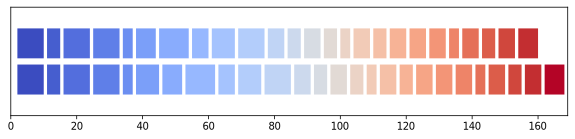

In [41]:
import matplotlib.pyplot as plt

# pip install mycolorpy
from mycolorpy import colorlist as mcp

nkr_pages1 = [(n[-2],n[-1]) for n in full_journal[-1][0]]
uni_pages1= [(u[-2],u[-1]) for u in full_journal[-1][1]]

fig, ax = plt.subplots(1,1,figsize=(10,2))

uni_color1 = mcp.gen_color(cmap="coolwarm",n=len(uni_pages1))
nkr_color1 = mcp.gen_color(cmap="coolwarm",n=len(nkr_pages1))

for idx, (min_int, max_int) in enumerate(uni_pages1):
      ax.hlines(y=i+10, xmin=min_int, xmax=max_int,linewidth=30,  color=uni_color1[idx], label=idx)
for idx, (min_int, max_int) in enumerate(nkr_pages1):
      ax.hlines(y=i+20, xmin=min_int, xmax=max_int,linewidth=30, color=uni_color1[idx],  label=idx)
ax.set_yticks([])
ax.set_xlim(0,169)
ax.set_ylim(0,30)
ax.set_facecolor('#ffffff')

plt.show()

Repeating the process for the philosophy journal:

In [42]:
def highlight(s):
    return ["background: yellow" if (s['UniKorea']["Title"] == remaining_missing[0][1][0][0] or s['UniKorea']["Title"] == remaining_missing[0][1][1][0]) else '' for s_ in s]

nkr_df = pd.DataFrame(full_journal[0][0], columns=['Title','Author','Start Page','End Page'], dtype=object)
uni_df = pd.DataFrame(full_journal[0][1], columns=['Title','Author','Start Page','End Page'], dtype=object)
philosophy_df = pd.concat({'NkResearch':nkr_df, 'UniKorea':uni_df}, axis=1)
philosophy_df_display = philosophy_df.style.apply(highlight, axis=1)
philosophy_df_display

We see that two entries (index 3,13) are similarly missing, yet the page range remains continuous.

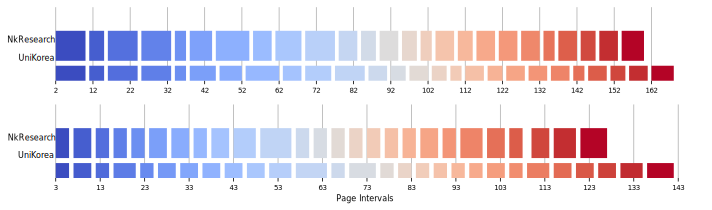

In [43]:

nkr_pages2 = [(n[-2],n[-1]) for n in full_journal[0][0]]
uni_pages2= [(u[-2],u[-1]) for u in full_journal[0][1]]

uni_color2=mcp.gen_color(cmap="coolwarm",n=len(uni_pages2))
nkr_color2=mcp.gen_color(cmap="coolwarm",n=len(nkr_pages2))

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,3),sharex=False)

for idx, (min_int, max_int) in enumerate(uni_pages1):
      ax1.hlines(y=i, xmin=min_int, xmax=max_int,linewidth=30, color=uni_color1[idx],)

for idx, (min_int, max_int) in enumerate(nkr_pages1):
      ax1.hlines(y=i+19, xmin=min_int, xmax=max_int, linewidth=30, color=nkr_color1[idx])
        
for idx, (min_int, max_int) in enumerate(uni_pages2):
      ax2.hlines(y=i, xmin=min_int, xmax=max_int,linewidth=30,  color=uni_color2[idx])

for idx, (min_int, max_int) in enumerate(nkr_pages2):
      ax2.hlines(y=i+19, xmin=min_int, xmax=max_int,linewidth=30, color=nkr_color2[idx])
ax2.set_xlabel('Page Intervals',ha='center',va='top',size=8)
ax2.set_yticks([])
ax1.set_yticks([])

plt.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout()
ax1.set_xticks(np.arange(2, 168, 10))
ax2.set_xticks(np.arange(3, 145, 10))

for ax in [ax1,ax2]:
    ax.set_ylim(0,40)
    ax.set_facecolor('#ffffff')
    ax.grid(True, which='both',color='#b0b0b0')
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


ax1.annotate('NkResearch', (-11, 19.95),size=8,ha='left',va='bottom', color='black', annotation_clip=False)
ax1.annotate('UniKorea', (-8, 10),size=8,ha='left',va='bottom', color='black', annotation_clip=False)

ax2.annotate('NkResearch', (-7.8, 19.5),size=8,ha='left',va='bottom',color='black', annotation_clip=False)
ax2.annotate('UniKorea', (-5.5, 10),size=8,ha='left',va='bottom',color='black', annotation_clip=False)
fig.tight_layout()
plt.savefig('page_intervals.png',dpi=1200)

plt.show()

**Each listing can be viewed at:**

[사회주의에 대한 신념교양의 도수를 높이는것은 현시기 우리 혁명의 중요한 요구](https://unibook.unikorea.go.kr/material/article?articleControlNo=365579&checkinNo=111244&materialScope=SER&nation=kn&format=image&pageSize=10&sortField=publishYear&sortDirection=DESCENDING&method=KEYWORD&fields=ALL&keywords=%EC%B2%A0%ED%95%99%2C%EA%B2%BD%EC%A0%9C&uid=CAT-00000000000064417)


[제국주의본성에 관한 독창적인 사상리론](https://unibook.unikorea.go.kr/material/article?articleControlNo=365579&checkinNo=111244&materialScope=SER&nation=kn&format=image&pageSize=10&sortField=publishYear&sortDirection=DESCENDING&method=KEYWORD&fields=ALL&keywords=%EC%B2%A0%ED%95%99%2C%EA%B2%BD%EC%A0%9C&uid=CAT-00000000000064417)


[우화창작에서 충동을 받는 다양한 계기](https://unibook.unikorea.go.kr/material/article?articleControlNo=364928&checkinNo=111294&materialScope=SER&nation=kn&format=image&pageSize=10&sortField=publishYear&sortDirection=DESCENDING&method=KEYWORD&fields=ALL&keywords=%EC%96%B4%EB%AC%B8%ED%95%99&uid=CAT-00000000000064415)
        

# Part V: Title Discrepancies

The aligned journals are now tested for string similarity of each title and author entry. 


In [44]:
for [journal,nkresearch,unikorea] in aligned_collection[:1]:
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        print (diff_strings(article[0],unikorea[i][0])+"; Levenshtein Distance of",levenshtein_distance(article[0],unikorea[i][0]))

고구려성의 건설설계연구; Levenshtein Distance of 0
고구려시기 무덤건설규정연구; Levenshtein Distance of 0
고조선에 대한 실학자들의 견해분석; Levenshtein Distance of 0
과학기술발전에서 새로운 비약을 이룩하며 과학으로 흥하는 시대를 열어놓은 불멸의 령도업적; Levenshtein Distance of 0
모란봉전자악단을 우리 당의 사상과 정책을 옹위하는 제일나팔수로 키워주신 불멸의 업적; Levenshtein Distance of 0
아랍나라들에서 《색갈혁명》의 파국적후과와 그 교훈; Levenshtein Distance of 0
인문주의력사학의 진보성과 제한성; Levenshtein Distance of 0
조선의 민속놀이 윷놀이에 대한 분석; Levenshtein Distance of 0
조선청년학생들의 애국적투지와 불굴의 기개를 시위한 광주학생운동; Levenshtein Distance of 0
사회주의보건제도의 우월성을 높이 발양시켜 나가기 위한 현명한 령도; Levenshtein Distance of 1


As shown above, most titles have an Levenshtein Distance of 0, meaning the strings are equal. For unequal titles,

In [45]:
for [journal,nkresearch,unikorea] in aligned_collection[:5]:
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        if article[0] != unikorea[i][0]:
            print (diff_strings(article[0],unikorea[i][0])+"; Levenshtein Distance of",levenshtein_distance(article[0],unikorea[i][0]))

사회주의보건제도의 우월성을 높이 발양시켜 나가기 위한 현명한 령도; Levenshtein Distance of 1
제2차 세계대전의 전패국-도이췰한란드와 일본의 과거청산에 대한 비교분석; Levenshtein Distance of 1
17세기 후반기이후 화폐페류통에 대한 실학자들의 견해와 그 진보성; Levenshtein Distance of 1
우리 나라에서 자본주의화폐페제도의 발생발전과 그것을 저해한 일본침략자들의 책동; Levenshtein Distance of 1
현대자본주의경제의 악성위기-－디플레; Levenshtein Distance of 1
ㅇ지구 동-－철광상의 특징; Levenshtein Distance of 1
림농복합경영구역에서의 사면휴경체계; Levenshtein Distance of 1
원격수감화상에서 K-－S검정에 의한 단층예측의 한가지 방법; Levenshtein Distance of 1
유기질석-－천연고무복합재료의 제조와 특성; Levenshtein Distance of 1
혜산시 춘동지구에서 새로 알려진 상부고생대 식물화석에 대하여; Levenshtein Distance of 1


we see that "different" strings (those not equal) have very miniscule string+/- as indicated by levenshtein distance = 1. 

In [46]:
lev_distances = []
for [journal,nkresearch,unikorea] in aligned_collection:
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        lev_distances.append(lev_dist)
print (make_bold("Average Levenshtein distance is"), sum(lev_distances)/len(lev_distances))

Average Levenshtein distance is 0.4217372134038801


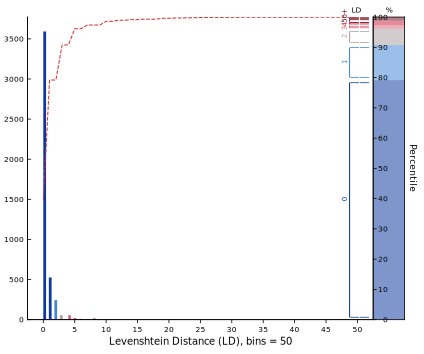

In [47]:
from scipy import stats
from collections import Counter,OrderedDict
import numpy as np
from matplotlib.lines import Line2D

colors = ['#002f9c','#3981d4','#a89b9d','#d95f72','#cf1534','#700316','#730014']
color_dict = dict(zip(list(range(7)),colors))

x = lev_distances
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(6,5), gridspec_kw={'width_ratios': [11, 1]})
counts, bins, patches = ax1.hist(x, density=False, bins=50, facecolor=colors[0], alpha=0.95)

ax1.set_xlabel('Levenshtein Distance (LD), bins = 50',size=10,)

percentiles = []
for lev in list(range(6)):
    percentiles.append(stats.percentileofscore(x,lev, kind='weak'))

ranges = []
ranges.append((0,percentiles[0]))
ranges.append((percentiles[0],percentiles[1]))
for i,p in enumerate(percentiles[1:-1]):
    ranges.append((p,percentiles[i+2]))
ranges.append((percentiles[-1],100))


for i,(start,end) in enumerate(ranges):
    ax2.axhspan(start, end, facecolor=colors[i],alpha=0.5)
    ax2.annotate("——",(-0.75, start), annotation_clip=False,color=colors[i],alpha=1)
    ax2.annotate("——",(-0.75, end-1.7), annotation_clip=False,color=colors[i],alpha=1)
    ax2.annotate('', xy=(-0.75, start+0.3), xytext=(-0.75, end-0.3),arrowprops=dict(arrowstyle='-',color=colors[i]),alpha=1, annotation_clip=False)

for i,(start,end) in enumerate(ranges[:3]):
    ax2.annotate(str(i), xy=(-1, ((start+end)/2)), annotation_clip=False,size=7, rotation=90,color=colors[i],alpha=1,)
for i,(start,end) in enumerate(ranges[3:-1]):
    ax2.annotate(str(i+3), xy=(-1, start), annotation_clip=False,size=7, rotation=90,color=colors[i+3])

ax2.annotate(str(6)+"+", xy=(-1, 100), annotation_clip=False,size=7, rotation=90,color=colors[-1])

ax2.annotate("LD", xy=(-0.69, 101.5), annotation_clip=False,size=7.5)
ax2.annotate("%", xy=(0.4, 101.5), annotation_clip=False,size=7.5)

for b,patch in zip(bins,patches):
    if b > 1:
        patch.set_facecolor(color_dict[1])
    if b > 2:
        patch.set_facecolor(color_dict[2])
    if b > 3:
        patch.set_facecolor(color_dict[3])
    if b > 4:
        patch.set_facecolor(color_dict[4])
    if b > 5:
        patch.set_facecolor(color_dict[5])
    if b > 6:
        patch.set_facecolor(color_dict[6])

ax1.set_xticks(np.arange(0, 51, 5))
ax2.set_yticks(np.arange(0, 101, 10))
ax2.set_xticks([])
ax2.yaxis.set_ticks_position("left")
ax2.set_ylabel('Percentile',size=9,rotation=270,labelpad=12)
ax2.yaxis.set_label_position("right")

ax2.tick_params(axis='both', which='major', labelsize=7.5, direction="in", pad=-15)
ax1.tick_params(axis='y', which='major', labelsize=7.5, direction="in")
ax1.tick_params(axis='x', which='major', labelsize=7.5)

ax3 = ax1.twinx()
ax3.plot(0, 1)
ax3.set_ylim(0,100)


percentile_x = list(range(len(bins)))
percentile_y = [stats.percentileofscore(x,b) for b in bins]
ax3.plot(percentile_x,percentile_y, linestyle='--', linewidth=1,color='tab:red')

ax3.set_yticks([])

ax2.set_xlim(0,1)
ax2.set_ylim(0,100)
fig.tight_layout()
fig.subplots_adjust(wspace=0.0, hspace=0)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax3.spines['top'].set_visible(False)

plt.savefig('levenshtein_distribution.png',dpi=1200)
plt.show()

In [48]:
a = np.array(lev_distances)

percentiles = []
for v in list(range(0,100)):
    p = np.percentile(a, v)
    p_str = str(v)+"th"
    percentiles.append([p_str,p])
df = pd.DataFrame(percentiles, columns=['Percentile','Levenshtein Distance'])
writer = pd.ExcelWriter('levenshtein_percentiles.xlsx', engine='xlsxwriter')
df.to_excel(writer, 'Sheet1')
writer.save()
df

,Percentile,Levenshtein Distance
0,0th,0.000000
1,1th,0.000000
2,2th,0.000000
3,3th,0.000000
4,4th,0.000000
...,...,...
95,95th,2.000000
96,96th,2.000000
97,97th,3.000000
98,98th,4.000000


In [49]:
lev_avg = []

for [journal,nkresearch,unikorea] in aligned_collection:
    temp = [levenshtein_distance(article[0],unikorea[i][0]) for i,article in enumerate(nkresearch)]
    average = sum(temp)/len(temp)
    lev_avg.append([journal[0],journal[1],journal[2],average])

df = pd.DataFrame(lev_avg,columns=["Subject","Volume","No","Average Levenshtein Distance"])
df = df.set_index(["Subject","Volume","No"])
writer = pd.ExcelWriter('levenshtein_avg.xlsx', engine='xlsxwriter')
df.to_excel(writer, 'Sheet1')
workbook = writer.book
worksheet = writer.sheets['Sheet1'] 
writer.save()
df

Average Levenshtein Distance
Subject      Volume No                              
력사학          65     2                       0.100000
                    1                       0.111111
경제학          65     2                       0.153846
                    1                       0.083333
지구환경과학 및 지질학 65     4                       0.185185
...                                              ...
자연과학         61     11                      0.088235
                    10                      0.083333
                    9                       0.189189
                    8                       0.108108
                    7                       0.305556

[148 rows x 1 columns]

Still, we will explore sources of all discrepancies.

### 1)  Differences in Unicode Special Characters

In [50]:
for [journal,nkresearch,unikorea] in aligned_collection[30:35]:
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        if lev_dist > 5:
            print (diff_strings(article[0],unikorea[i][0])+"; LD of",lev_dist)

환원성분위기에서 Sr₃3SiO₅ : 5：Eu²⁺2+형광체의 직접합성; LD of 7
N,N''-′′－메틸렌-－비스[N'-′－(3-－히드록시메틸-－2,5-－디옥소-－4-－이미다졸리디닐)]뇨소의 합성; LD of 11
백색LED용 Li₂2SrSiO₄ : 4：Eu²⁺2＋황색형광체의 구조와 발광특성; LD of 7
웃전환형광성을 가진 NaGdF₄ : 4：Yb³⁺3+,Er³⁺3+ 나노립자의 용매열합성; LD of 8
1,3-－비스(2-－(4-－에틸피페라진-－1-1－일)-－2-－옥소에틸)피리미딘-－2,4-－디온의 합성과 분리분석에 대한 연구; LD of 10
Ba₄4(Si₃3O₈8)₂2:Eu²⁺2+형광체의 합성과 특성에 대한 연구; LD of 6
3-－(안트라센-－9-－일)-－펜탄-－2,4-－디온의 합성; LD of 6
수열법으로 합성한 KNbWO₆6·H₂2O : ：Eu³⁺3+,Tb³⁺3+의 발광특성; LD of 9


For instance, while the title & author combination as shown below appear identical, but the recurring difference in symbols used in the line notation, such as － & - and ′ & ', account for a levenshtein of distance 11, one of the highest values.

In [51]:
df = pd.DataFrame([collection[19] for collection in aligned_collection[32][-2:]],index=["NkResearch","UniKorea"],columns=['Title', 'Author']).T
df = df.style.set_table_attributes('style="font-size: 12px"')
df

,NkResearch,UniKorea
Title,"N,N′′－메틸렌－비스[N′－(3－히드록시메틸－2,5－디옥소－4－이미다졸리디닐)]뇨소의 합성","N,N''-메틸렌-비스[N'-(3-히드록시메틸-2,5-디옥소-4-이미다졸리디닐)]뇨소의 합성"
Author,"한문국,조완성,황명조","한문국,조완성,황명조"


A related class are the differences in symbols used to indicate book titles.

In [52]:
for [journal,nkresearch,unikorea] in aligned_collection[69:72]:
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        if lev_dist > 3:
            print (diff_strings(article[0],unikorea[i][0]))

1920년대 조선농촌에서 감행한 <<《동척>>》이민들의 범죄행위
<<《신탁통치>>》의 간판밑에 조선에 대한 지배를 노린 미제의 책동
미제는 남조선괴뢰<<《대통령>>》을 지배하고 조종하는 실제적인 통치자
우리 나라에서 감행된 일제의 식민지<<《총독통치>>》의 반동적성격
미제으<<의 《태평양국가>>》론과 그 위험성
자본주의 민사재판에서 <<《자유심증주의>>》의 기만성
<<《송서>>》고구려국전의 사료적가치와 제한성


### 2) UniKorea's exclusion of title parts
UniKorea occasionally missed some parts of the title, accounting for some of the largest levenshtein distances (>11).

In [53]:
for idx in [38,106,138]:
    [journal,nkresearch,unikorea] = aligned_collection[idx]
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        if lev_dist > 11:
            print (diff_strings(article[0],unikorea[i][0]),"; Levenshtein Distance of",levenshtein_distance(article[0],unikorea[i][0]))
            break

일반화된 해석정밀형삽입원자방법에 의한 Zr의 포논분산특성연구 ; Levenshtein Distance of 21
프랑스어동사 《avoir(소유하다)》의 의미적기능에 대한 리해 ; Levenshtein Distance of 13
GSP도표를 리용한 학생능력 및 문제난도평가의 한가지 방법 ; Levenshtein Distance of 12


However, manually checking the associated PDF of the article verified that these "missed" title parts tended to be multi-lined titles in which a row, or multiple rows, were eliminated. For instance, the official listing for the first title is viewable at http://www.ryongnamsan.edu.kp/univ/plugins/pdfviewer/web/viewer.html?file=1a77befc3b608d6ed363567685f70e1ekoj, and confirms UniKorea's incomplete multi-lined title.

### 3) UniKorea's Typos
Though accounting for a relatively smaller Levenshtein distance, there are occasional "replacements"; examining these errors, it seems most arise from errors in manual labor, which there is little room in NkResearch's programmatically generated metadata. For instance, in


In [54]:
journal,nkresearch,unikorea = aligned_collection[130]
print (diff_strings(nkresearch[19][0],unikorea[19][0]))
print ("Levenshtein Distance of:",levenshtein_distance(nkresearch[19][0],unikorea[19][0]))

frnwhanfㄹ구조물의 유한요소해석에 대한 연구
Levenshtein Distance of: 8


we see that English was accidentally used in place of the Korean qwerty keys, accounting for a relatively high distance of 8. Though the string "frnwhanf" is equal to "ㄹ구조물의" on the keyboard layout, this issue is highly unlikely to arise during automated processing.

In [55]:
# More examples
collection_list = [[1,3,50,0],[62,63,19,18],[67,68,26,18],[70,74,26,16]]
for x,y,z,k in collection_list:
    for collection in aligned_collection[x:y]:
        nkresearch,unikorea = collection[-2:]
        for i,article in enumerate(nkresearch[k:z]):
            lev_dist = levenshtein_distance(article[0],unikorea[i+k][0])
            if lev_dist > 0:
                print (diff_strings(article[0],unikorea[i+k][0]))

제2차 세계대전의 전패국-도이췰한란드와 일본의 과거청산에 대한 비교분석
17세기 후반기이후 화폐페류통에 대한 실학자들의 견해와 그 진보성
우리 나라에서 자본주의화폐페제도의 발생발전과 그것을 저해한 일본침략자들의 책동
미국형법에 규제된 <<《중간처벌>>》과 그 반동성
위대한 령도자 김정일동지께서 1980년대 혁명발전의 요구에 맞게 일하면서 배우는 고등교육체계를 더욱 발전시키도록 이끄신 현령명한 령도
위대한 령도자 김정일동지께서 조작직령도하신 고난의 행군, 강행군시기 룡문대굴을 비롯한 나라의 명승지들을 세계적인 명승지로 꾸리기 위한 투쟁
위대한 령도자 김정일동지께서 조직령도하신 민족유산보호 부문에서 반당반혁명분자들의 사상여독을 청산하고 당의 유일사상체계를 세우기 위한 투쟁
위대한 수령 김일성동지의 현명한 령도밑에 새 조국건설시기 청년들속에서 증산경재쟁운동을 힘차게 조직전개하기 위한 민청단체들의 투쟁
위대한 수령 김일성동지의 현명한 령도밑에 조국해방 전쟁시기 세계 진보적청년들과의 련대성을 강화하기 위한 청년동맹대외활동
위대한 수령 김일성종동지의 현명한 령도밑에 조국해방전쟁시기 우리 인민국군장병들과 인민들이 발휘한 영웅적투쟁
위대한 형령도자 김정일동지께서 선국군혁명령도의 계승문제를 빝빛나게 해결하신 불멸의 업적
랭전종식후 미제가 감행한 남조선괴뢰들의 군사장비 현대화책동의 특징
미제으<<의 《태평양국가>>》론과 그 위험성
소할바령회의는 항일무장투쟁이 종국적증승리를 위한 새로운 력사적단계에로 확신성있게 들어설수 있게 한 력사적인 회의
위대한 김정일동지께서 1980년대 군중문화학창작에서 새로운 앙양을 일으시킨키신 현명한 령도
위대한 김정일동지께서 경제선동의 북소리 높이 올울려 선군혁명종총진군을 힘있게 추동하도록 이끄신 현명한 령도
<<《송서>>》고구려국전의 사료적가치와 제한성
문화교류를 통한 대외전선전사업을 현명하게 이끄신 위대한 김정일동지의 불멸의 령도
공업기업소들에서 설비리용틀률계산과 분석방법


For instance, in this one title alone,

In [56]:
collection_list = [[67,68,26,18]]
for x,y,z,k in collection_list:
    for [journal,nkresearch,unikorea] in aligned_collection[x:y]:
        for i,article in enumerate(nkresearch[k:z]):
            lev_dist = levenshtein_distance(article[0],unikorea[i+k][0])
            if lev_dist > 2:
                print (diff_strings(article[0],unikorea[i+k][0]))

위대한 형령도자 김정일동지께서 선국군혁명령도의 계승문제를 빝빛나게 해결하신 불멸의 업적


there is an obvious misspelling of "위대한 령도자" ("Our Supreme Leader") into -> "위대한 <font color='red'>형</font>도자" (not a word; 형 means brother),  "선군" ("Songun, North Korea's military ideology") into -> "선<font color='red'>국</font>", and "빛" (light) into -> "<font color='red'>빝</font>" (not a word). Note that both ㄹ&ㅎ ㅊ&ㅌ are neighbors on the Korean qwerty keyboard.

Another type of this error seems to arise from North Korean specific languages, in which they were misspelled or incorrectly spelled using the South Korean standard. For instance, in

In [57]:
e = []
for [journal,nkresearch,unikorea] in aligned_collection[1:3]:
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        if article[0] != unikorea[i][0]:
            e.append(diff_strings(article[0],unikorea[i][0]))
            print (diff_strings(article[0],unikorea[i][0])+"; Levenshtein Distance of",levenshtein_distance(article[0],unikorea[i][0]))


제2차 세계대전의 전패국-도이췰한란드와 일본의 과거청산에 대한 비교분석; Levenshtein Distance of 1
17세기 후반기이후 화폐페류통에 대한 실학자들의 견해와 그 진보성; Levenshtein Distance of 1
우리 나라에서 자본주의화폐페제도의 발생발전과 그것을 저해한 일본침략자들의 책동; Levenshtein Distance of 1


the first line incorrectly used  "도이췰한드" in place of "도이췰란드", which is North Korean for "Germany" (https://ko.dict.naver.com/#/correct/korean/info?seq=1001552). The next two state "화폐" (currency) in place of "화페", which the National Institute of Korean Language (https://opendict.korean.go.kr/dictionary/view?sense_no=323372&viewType=confirm) confirms it as the North Korean equivalent.

The above cases were drafted by referencing the deviations (Levenshtein Distance > 4) below: 

In [58]:
for ii,[journal,nkresearch,unikorea] in enumerate(aligned_collection):
    for i,article in enumerate(nkresearch):
        lev_dist = levenshtein_distance(article[0],unikorea[i][0])
        if lev_dist > 4:
            print (diff_strings(article[0],unikorea[i][0]))

논벼계통 <〈중-－2>〉와 품종 <《평도 11>》호의 섞붙임후대에서 염견딜성이 높은 계통선발
N,N-－비스(N-－아세틸-－2-－피롤리돈-－5-－카르보닐)-－2,4-－디옥소피리미딘의 합성과 분리분석
N-－아세틸-－2-－피톨롤리돈-－5-－카르본산의 합성과 분리분석
환원성분위기에서 Sr₃3SiO₅ : 5：Eu²⁺2+형광체의 직접합성
N,N''-′′－메틸렌-－비스[N'-′－(3-－히드록시메틸-－2,5-－디옥소-－4-－이미다졸리디닐)]뇨소의 합성
백색LED용 Li₂2SrSiO₄ : 4：Eu²⁺2＋황색형광체의 구조와 발광특성
웃전환형광성을 가진 NaGdF₄ : 4：Yb³⁺3+,Er³⁺3+ 나노립자의 용매열합성
1,3-－비스(2-－(4-－에틸피페라진-－1-1－일)-－2-－옥소에틸)피리미딘-－2,4-－디온의 합성과 분리분석에 대한 연구
Ba₄4(Si₃3O₈8)₂2:Eu²⁺2+형광체의 합성과 특성에 대한 연구
3-－(안트라센-－9-－일)-－펜탄-－2,4-－디온의 합성
F-－T합성에서 Fe-－K-－Cu-－Co-－Si촉매의 반응특성
수열법으로 합성한 KNbWO₆6·H₂2O : ：Eu³⁺3+,Tb³⁺3+의 발광특성
6,6'-′－메틸렌비스(4-－클로로-－2-－히드록시메틸페녹시초산나트리움)의 합성
KOH처리에 의한 KBF₄4 에서의 K₂2SiF₆6 제거
제1원리전에네르기에 기초한 용매화된 Cs⁺+, Pb²⁺2+, I⁻-의 화학포텐샬평가방법
금강석합성에 리용되는 Ni₄₀40Mn₃₀30Fe₃₀30, Ni₇₀70Mn₂₅25Co₅5합금촉매의 금속학적특성
일반화된 해석정밀형삽입원자방법에 의한 Zr의 포논분산특성연구
유기-무기혼성재료 CH₃3NH₃3Pb(I₁₋ₓ1−xClₓx)₃3의 고유안정성에 대한 제1원리적연구
Pb(Mn₁1/₃3Nb₂2/₃3)ZrTiO₃3압전사기재료의 특성에 미치는 Sr치환효과
무기페로브스카이트고용체 CsₓxRb₁₋ₓ1−xPbI₃3의 살창구조와 전자적성질
태양빛전지용 CsₓxRb₁₋ₓ1−xPbI₃3무기페로브스카이트고용체의 광학적성질에 대한 제1원리적연구
γ선측정법에 기초한 ²